# FALTAN COSAS, HE PUESTO TODO LO QUE TENIA A MANO DEL PROBLEMA INDIVIDUAL QUE ERA BASICAMENTE COPYPASTE Y CAMBIAR CUATRO COSAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

a) El primer paso es preprocesar y preparar los datos antes de ajustar cualquier modelo. Hay
algunas variables que no son útiles para el problema o que no tiene sentido usar. Eliminadlas del conjunto de datos. Dividid los datos en conjuntos de entrenamiento y test1
(60 %
/40 %). Haced una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables, especialmente con la variable objetivo. Describid las
cosas que hayáis visto que os parezcan interesantes. Estandarizad las variables (calculad
el estandarizador a partir de los datos del entrenamiento y luego aplicadlo a los datos de
test).

In [2]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344,0.364,0.806,0.160,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363,0.354,0.696,0.249,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196,0.189,0.437,0.248,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200,0.212,0.590,0.160,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.227,0.229,0.437,0.187,82,1518,1600


In [3]:
df = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344,0.364,0.806,0.160,985
1,1,0,1,0,0,0,2,0.363,0.354,0.696,0.249,801
2,1,0,1,0,1,1,1,0.196,0.189,0.437,0.248,1349
3,1,0,1,0,2,1,1,0.200,0.212,0.590,0.160,1562
4,1,0,1,0,3,1,1,0.227,0.229,0.437,0.187,1600


In [5]:
X = df.loc[:,df.columns != 'cnt']
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [39]:
data_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

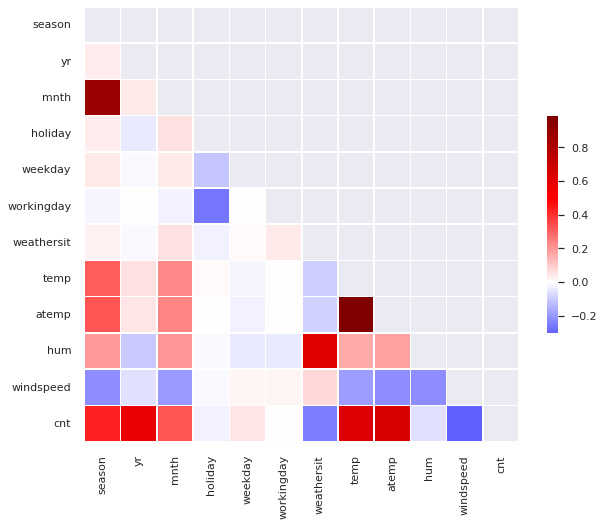

In [15]:
trainData = X_train.copy()
trainData = trainData.assign(cnt=y_train.values)
corr = trainData.corr()
fig = plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.show()

Podemos ver como las variables season, year, month, temp y atemp tienen una correlación positiva con la variable objetivo, mientras que weathersit y windspeed tienen correlación negativa. El resto de variables aportan prácticamente nada a la variable objetivo.

In [74]:
sc = StandardScaler()
X_train_st = X_train.copy()
X_train_st[data_columns] = sc.fit_transform(X_train[data_columns])
X_test_st = X_test.copy()
X_test_st[data_columns] = sc.transform(X_test[data_columns])

b) Aplicad algún método de reducción de dimensionalidad a los datos de entrenamiento y
comentad lo que se pueda apreciar en la visualización. Pensad en qué podéis representar
sobre la transformación.

In [42]:
from sklearn.decomposition import PCA

In [43]:
myPCA = PCA().fit(X_train_st);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.24616561 0.14971135 0.12297359 0.11634369 0.09167232 0.08802189
 0.08317804 0.06462174 0.02603432 0.01030682 0.00097062]
[0.24616561 0.39587696 0.51885055 0.63519425 0.72686657 0.81488846
 0.89806651 0.96268825 0.98872256 0.99902938 1.        ]


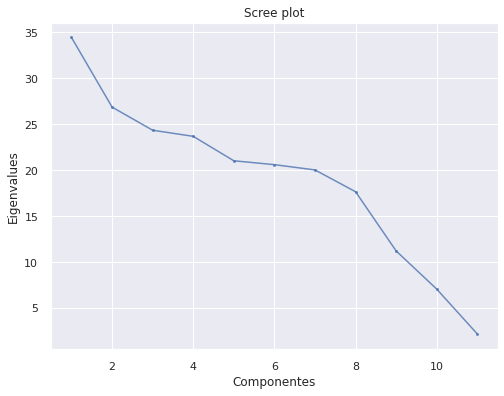

In [44]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
y_label = plt.ylabel('Eigenvalues');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

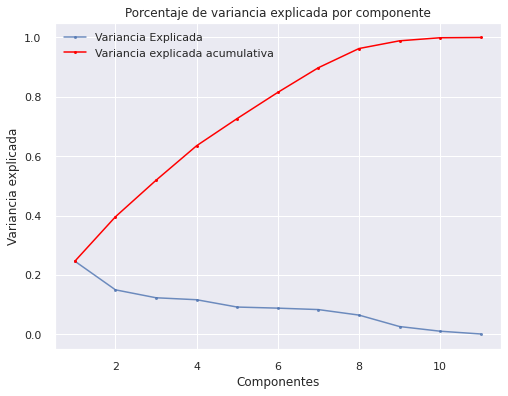

In [45]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

In [77]:
pcadataset = myPCA.transform(X_train_st)
df = X_train_st.copy()
df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']] = pcadataset[:,:6]

pcadatasettest = myPCA.transform(X_test_st)
dftest = X_test_st.copy()
dftest[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']] = pcadatasettest[:,:6]

In [48]:
pcacolumns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

In [49]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,PC1,PC2,PC3,PC4,PC5,PC6
107,-0.480,-1.009,-0.725,-0.175,-0.997,0.667,-0.740,0.107,0.193,-0.590,-0.350,0.559,-0.965,-0.621,0.227,0.158,-1.444
133,-0.480,-1.009,-0.434,-0.175,1.518,-1.498,1.101,0.152,0.178,2.105,-0.708,-0.484,1.837,-0.862,1.081,1.402,1.679
418,-1.387,0.991,-1.306,-0.175,0.512,0.667,-0.740,-0.209,-0.163,-0.504,-0.008,1.532,-1.150,-0.919,-0.374,-0.597,0.759
223,0.426,-1.009,0.437,-0.175,1.015,0.667,-0.740,1.167,1.108,-1.495,-0.824,-1.212,-1.737,-0.062,-0.897,1.338,-0.237
549,0.426,0.991,0.147,-0.175,-0.494,0.667,-0.740,1.559,1.403,-0.948,-0.817,-1.636,-1.999,-0.595,-0.375,-0.942,-0.183


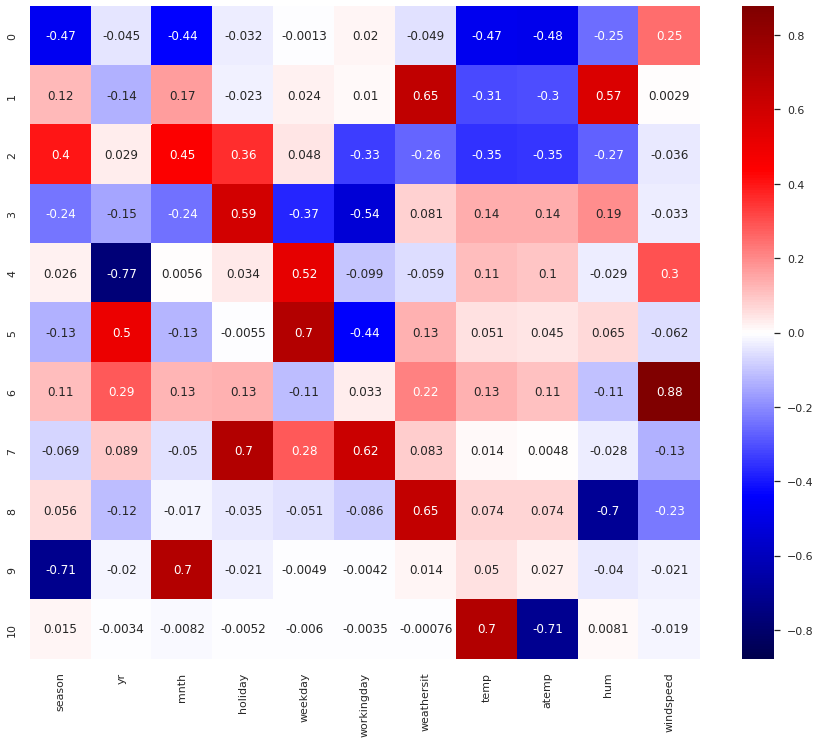

In [51]:
fig = plt.figure(figsize=(15,12));
sns.heatmap(myPCA.components_, cmap='seismic', 
            xticklabels=list(df[data_columns].columns),
            vmin=-np.max(np.abs(myPCA.components_)),
            vmax=np.max(np.abs(myPCA.components_)),
            annot=True);

c) La variable a predecir es un conteo. En este caso podría tener sentido utilizar un regresor que use un modelo adecuado para este tipo de datos como el PoissonRegressor de
scikit-learn. Veréis que tiene un parámetro de regularización alpha que necesitaréis ajustar usando validación cruzada. Con el mejor parámetro de regularización según el error de
validación cruzada, ajustad el modelo con los datos de entrenamiento y calculad la calidad
del modelo con los datos de test.


In [100]:
from sklearn.linear_model import PoissonRegressor

In [101]:
lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
max = 0
besta = 1
for a in lambdas:
  pr = PoissonRegressor(alpha=a)
  mean = np.mean(cross_val_score(pr, X_train_st[data_columns], y_train))
  if mean > max: 
    max = mean
    besta = a

print(besta)

100


In [102]:
pr = PoissonRegressor(alpha=besta)
pr.fit(X_train_st, y_train)
y_pred = pr.predict(X_test_st)
print("R2 score: " , r2_score(y_test, y_pred))

R2 score:  0.7489246289768816


In [92]:
max = 0
besta = 1
for a in lambdas:
  pr = PoissonRegressor(alpha=a)
  mean = np.mean(cross_val_score(pr, df[pcacolumns], y_train))
  if mean > max: 
    max = mean
    besta = a

print(besta)

100


In [82]:
pr = PoissonRegressor(alpha=besta)
pr.fit(df[pcacolumns], y_train)
y_pred = pr.predict(dftest[pcacolumns])
print("R2 score: " , r2_score(y_test, y_pred))

R2 score:  0.7267639988080455


d) A veces el modelo que parece adecuado no lo es tanto después de todo. Ajustad una regresión lineal a los datos y calculad la calidad del modelo empleando validación cruzada
y con los datos de test.

In [84]:
lr = LinearRegression()

lr.fit(df[pcacolumns],y_train)

y_pred = lr.predict(dftest[pcacolumns])

In [86]:
print("R2 score: " , r2_score(y_test, y_pred))

R2 score:  0.7655104826008335


In [103]:
lr = LinearRegression()

lr.fit(df[data_columns],y_train)

y_pred = lr.predict(dftest[data_columns])

In [89]:
print(np.mean(cross_val_score(lr, df[data_columns], y_train)))

0.7744109688958343


In [90]:
print("R2 score: " , r2_score(y_test, y_pred))

R2 score:  0.7900262352558771


In [ ]:
plt.figure(figsize=(12,8))
viz2 = residuals_plot(lasso_cv, df[data_columns], y_train, dftest[data_columns], y_test, is_fitted=True, qqplot=True, hist=False)

e) Cuando se trata de entender un problema, es útil reducir el número de atributos en el modelo. Ajustad una regresión LASSO (ajustando la regularización usando la versión CV del
modelo) y calculad la calidad del modelo con los datos de test.

In [95]:
lasso_cv =LassoCV(alphas=lambdas,cv=5).fit(df[pcacolumns],y_train)

y_pred = lasso_cv.predict(dftest[pcacolumns])

print("R2 score: " , r2_score(y_test, y_pred))

R2 score:  0.762926021334119


In [104]:
lasso_cv =LassoCV(alphas=lambdas,cv=5).fit(df[data_columns],y_train)

y_pred = lasso_cv.predict(dftest[data_columns])

print("R2 score: " , r2_score(y_test, y_pred))

R2 score:  0.7890587769665942


In [97]:
from yellowbrick.regressor import residuals_plot

f) Ahora podemos analizar y comparar los resultados:
Comparad los valores pronosticados con los valores reales de los tres modelos y sus
calidades. ¿Qué modelo os parece mejor? ¿Por qué?
Analizad los pesos de la regresión lineal y LASSO. ¿Qué atributos son más importantes? ¿Hay atributos que no son relevantes?
Comparad las predicciones de la regresión de Poisson y la regresión de LASSO. ¿Hay
alguna diferencia en su comportamiento? ¿Qué creéis que está pasando?


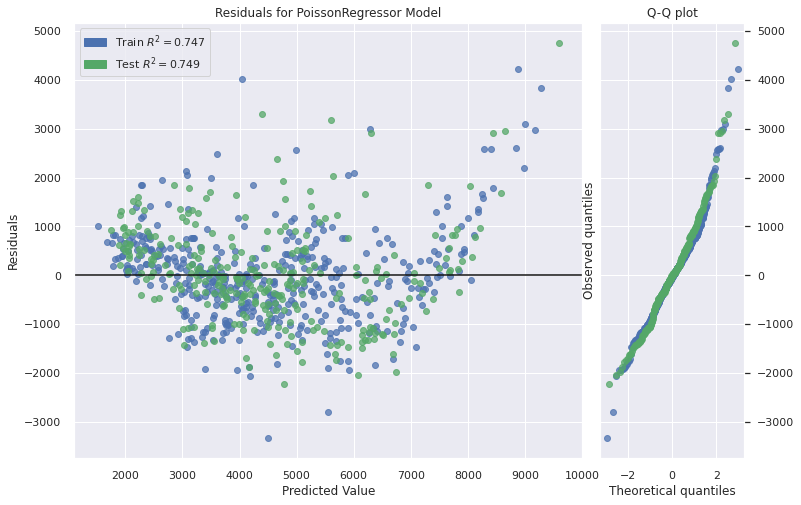

In [105]:
plt.figure(figsize=(12,8));
viz2 = residuals_plot(pr, df[data_columns], y_train, dftest[data_columns], y_test, is_fitted=True, qqplot=True, hist=False);

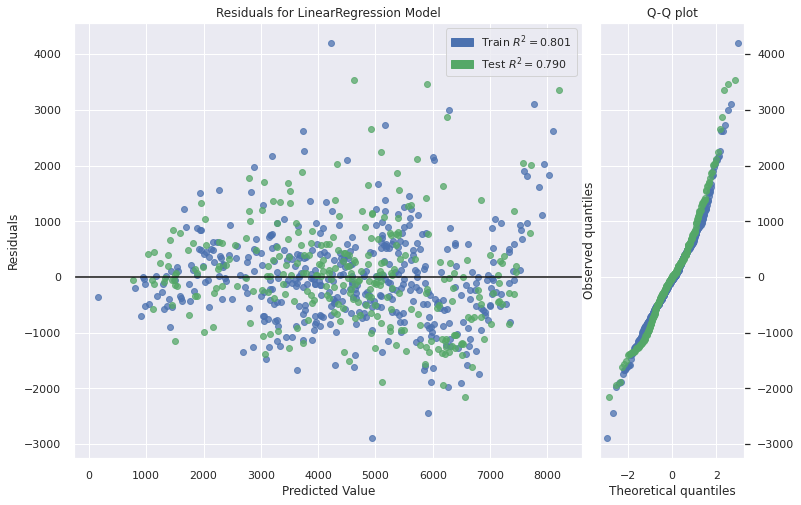

In [106]:
plt.figure(figsize=(12,8));
viz2 = residuals_plot(lr, df[data_columns], y_train, dftest[data_columns], y_test, is_fitted=True, qqplot=True, hist=False);

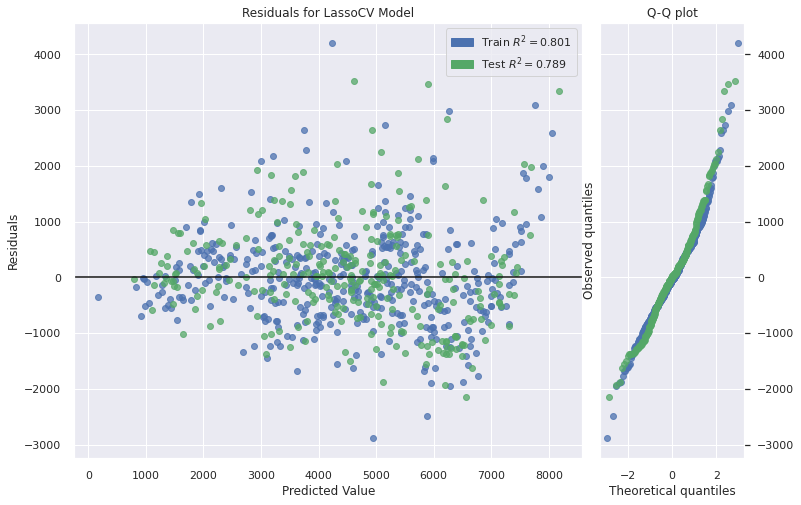

In [107]:
plt.figure(figsize=(12,8));
viz2 = residuals_plot(lasso_cv, df[data_columns], y_train, dftest[data_columns], y_test, is_fitted=True, qqplot=True, hist=False);

Analizando los residual plots de los tres modelos, modemos ver que la regresión lineal y la LASSO son prácticamente idénticas, mientras que la poisson es notablemente peor (se ajusta menos en el residual plot y tiene un r2 score peor). 

In [112]:
weights = pd.DataFrame({'lr':lr.coef_, 'lasso_cv': lasso_cv.coef_}, index=data_columns)
weights.T

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
lr,606.649,985.956,-172.858,-28.811,106.017,9.058,-284.953,536.214,405.263,-132.980,-242.381
lasso_cv,566.314,981.238,-131.906,-26.450,101.146,4.968,-283.769,534.597,405.828,-129.114,-237.859


Podemos ver que los atributos menos importantes son workingday y holiday. Los que más aportan a la regresión son yr, season, temp y atemp. Los atributos mnth, windspeed, weathersit y hum afectan, pero no con tanta intensidad.

Con esto podemos concluir que los factores que más afectan al uso total de bicicletas en un día son el año y estación en que estamos, así como la temperatura, seguidos de el tiempo que hace. Si el día es laborable o festivo no parece afectar demasiado, aunque en días festivos se tiende a usar las bicicletas algo menos que los laborables según los parámetros.

In [113]:
weights = pd.DataFrame({'poisson':pr.coef_, 'lasso_cv': lasso_cv.coef_}, index=data_columns)
weights.T

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
poisson,0.132,0.218,-0.013,-0.014,0.019,4.509e-04,-0.068,0.095,0.120,-0.024,-0.052
lasso_cv,566.314,981.238,-131.906,-26.450,101.146,4.968e+00,-283.769,534.597,405.828,-129.114,-237.859


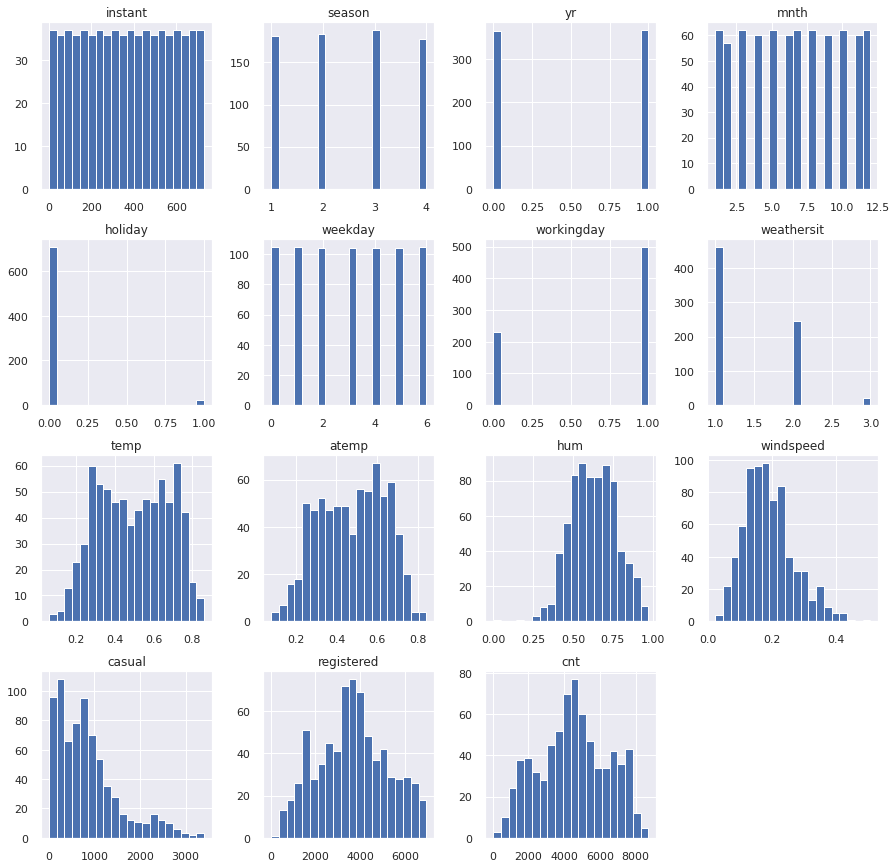

In [120]:
data = pd.read_csv('day.csv')
data.hist(bins=20, figsize=(15,15))
plt.show()

Parece que los pesos en general son proporcionales entre las dos regresiones, con la excepción de mnth, holiday y weekday, donde la regresión poisson asigna más peso a holiday que la lasso, y menos a mnth y weekday. 

Creemos que funciona mejor la lasso que la poisson porque, observando los histogramas de las variables, parece que se comportan mas como una distribución normal.